<a href="https://colab.research.google.com/github/AlexeyTri/Yolo8-app/blob/main/YOLO8_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
!pip install ultralytics==8.0.20

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.2/261.2 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

import json
import os
import shutil

from tqdm import tqdm
from pprint import pprint
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 25.8/107.7 GB disk)


In [4]:
from ultralytics import YOLO

from IPython.display import display, Image

Подключаем ЯНДЕКС-диск и загружаем БД с фотографиями

In [5]:
!wget https://gist.githubusercontent.com/Yegorov/dc61c42aa4e89e139cd8248f59af6b3e/raw/20ac954e202fe6a038c2b4bb476703c02fe0df87/ya.py
!chmod +x ya.py
!./ya.py https://disk.yandex.ru/d/Rx6PNLfOakcttw /content/sample_data/dataset

--2023-02-28 19:34:23--  https://gist.githubusercontent.com/Yegorov/dc61c42aa4e89e139cd8248f59af6b3e/raw/20ac954e202fe6a038c2b4bb476703c02fe0df87/ya.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 723 [text/plain]
Saving to: ‘ya.py’

ya.py               100%[===================>]     723  --.-KB/s    in 0s      

2023-02-28 19:34:23 (56.7 MB/s) - ‘ya.py’ saved [723/723]

--2023-02-28 19:34:25--  https://downloader.disk.yandex.ru/zip/8325e261fa1b16ca55ed454a445fe152210eb7a2c769340d4deaef62e03f82a5/63fe57b9/RWxIWm1OS1hGaGh4TlRUdjM0MXYxWWhvUnF0K1RseU5rTHRubGdXQ0gzM3lsWVAxa2FRQlRUZFJveklLa0ZLcUc3cFdwVlFZc3VieXJjYWpIaW1QRnc9PTo=?uid=0&filename=%D0%94%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%D1%8B.zip&disposition=attachment&hash=ElHZmNKXFhhxNTTv341v1YhoRqt%2BTly

In [6]:
!unzip Датасеты.zip -d datasets

Archive:  Датасеты.zip
  inflating: datasets/Датасеты/Персонал/dataset/annotation_data.json  
  inflating: datasets/Датасеты/Персонал/dataset/coco_categories.json  
  inflating: datasets/Датасеты/Персонал/dataset/images/2020-10-16/_1/_1_000250.jpg  
  inflating: datasets/Датасеты/Персонал/dataset/images/2020-10-16/_1/_1_002450.jpg  
  inflating: datasets/Датасеты/Персонал/dataset/images/2020-10-16/_10/_10_001875.jpg  
  inflating: datasets/Датасеты/Персонал/dataset/images/2020-10-16/_10/_10_004000.jpg  
  inflating: datasets/Датасеты/Персонал/dataset/images/2020-10-16/_10/_10_014700.jpg  
  inflating: datasets/Датасеты/Персонал/dataset/images/2020-10-16/_10/_10_016525.jpg  
  inflating: datasets/Датасеты/Персонал/dataset/images/2020-10-16/_10/_10_018250.jpg  
  inflating: datasets/Датасеты/Персонал/dataset/images/2020-10-16/_10/_10_019350.jpg  
  inflating: datasets/Датасеты/Персонал/dataset/images/2020-10-16/_10/_10_019500.jpg  
  inflating: datasets/Датасеты/Персонал/dataset/images/2

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
with open('/content/datasets/Датасеты/Персонал/dataset/annotation_data.json') as annotations_file:
    annotations_js = json.load(annotations_file)
    print('Annotations')
    print(annotations_js.keys())
    
with open('/content/datasets/Датасеты/Персонал/dataset/coco_categories.json') as coco_categories_file:
    coco_categories_js = json.load(coco_categories_file)
    print('Coco categories')
    print(coco_categories_js.keys())
    pprint(coco_categories_js['categories'])

Annotations
dict_keys(['categories', 'annotations', 'images', 'licenses'])
Coco categories
dict_keys(['categories'])
[{'color': [0, 255, 0],
  'exclude': False,
  'id': 3,
  'is_primary': True,
  'is_violation': False,
  'keypoints': [],
  'keypoints_style': [],
  'name': 'person',
  'ru_name': 'Человек',
  'supercategory': 'person',
  'threshold': 0.7},
 {'color': [0, 127, 0],
  'exclude': False,
  'id': 10,
  'is_primary': True,
  'is_violation': False,
  'keypoints': [],
  'keypoints_style': [],
  'name': 'person_nik',
  'ru_name': 'Персонал НИК',
  'supercategory': 'person',
  'threshold': 0.7},
 {'color': [0, 255, 0],
  'exclude': False,
  'id': 4,
  'is_primary': False,
  'is_violation': False,
  'keypoints': [],
  'keypoints_style': [],
  'name': 'vest',
  'ru_name': 'Жилет',
  'supercategory': 'vest',
  'threshold': 0.7},
 {'color': [0, 0, 255],
  'exclude': False,
  'id': 5,
  'is_primary': False,
  'is_violation': True,
  'keypoints': [],
  'keypoints_style': [],
  'name': 'v

In [9]:
categories_dict = dict()
for category in annotations_js['categories']:
    categories_dict[category['id']] = category['name']
pprint(categories_dict)

{3: 'person',
 4: 'vest',
 5: 'vest_viol',
 6: 'helmet',
 7: 'helmet_viol',
 8: 'welding_mask',
 9: 'head_hood',
 10: 'person_nik',
 11: 'head_unknown'}


In [10]:
for filename in os.scandir('/content/datasets/Датасеты/Персонал/dataset/images'):
    print(filename, end=" ")

<DirEntry '2020-10-20_2'> <DirEntry '2020-10-16'> <DirEntry '2020-10-17'> <DirEntry '2020-10-28'> <DirEntry '2020-10-20_3'> <DirEntry '2020-10-20_1'> 

In [11]:
images_dict = dict()
for image in annotations_js['images']:
    images_dict[image['id']] = image['file_name']
print(images_dict[1000000])

NIK_2020-10-28/1_3_2020_10_26-06_28_12.701.jpg


In [12]:
annotations_df = []
for annotation in tqdm(annotations_js['annotations']):
    tmp = {
        'image_id': annotation['image_id'],
        'image_path': images_dict[annotation['image_id']],
        'category_id': annotation['category_id'],
        'category_name': categories_dict[annotation['category_id']],
        'bbox': list(map(lambda x: round(x, 2), annotation['bbox'])),
        'area': annotation['area']
    }
    annotations_df.append(tmp)

annotations_df = pd.DataFrame(annotations_df)

100%|██████████| 21275/21275 [00:00<00:00, 85536.26it/s]


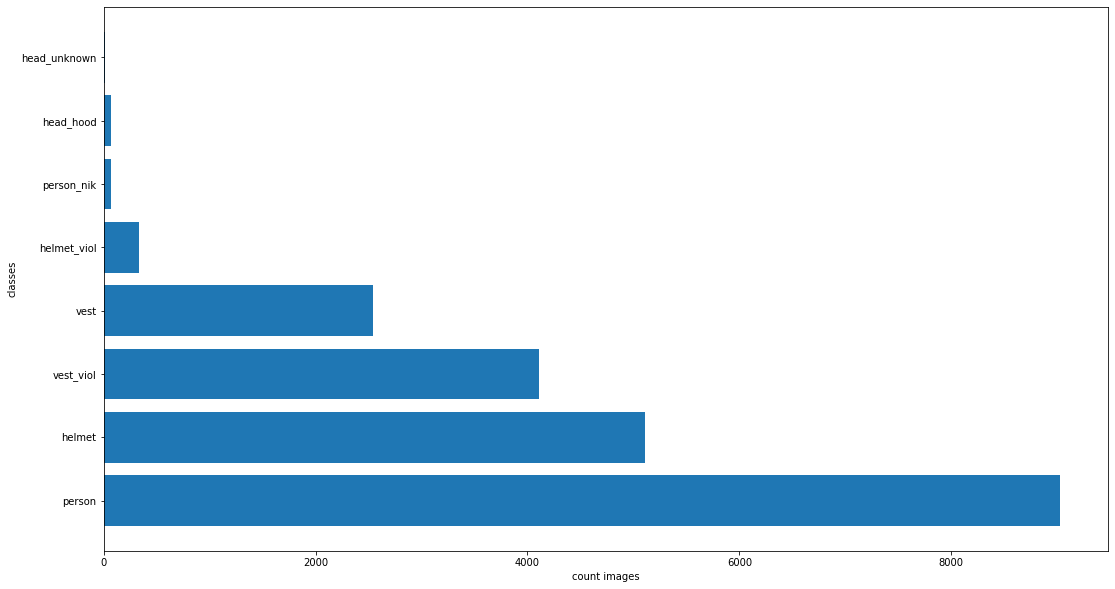

In [13]:
vc = annotations_df['category_name'].value_counts()

plt.figure(figsize=(18,10))
plt.barh(vc.index, vc.values)
plt.ylabel('classes')
plt.xlabel('count images')
plt.show()

In [ ]:
# def image_description_yolo8(image_data: pd.DataFrame, path: str = '/content/datasets/Датасеты/Персонал/dataset/images') -> np.array:
#     image_id = image_data['image_id'].values[0]
#     image_path = image_data['image_path'].values[0][4:]
#     img = cv2.cvtColor(
#         cv2.imread(os.path.join(path, image_path)),
#         cv2.COLOR_BGR2RGB
#     )
#     img_height, img_width, _ = img.shape
#     result_description = []
    
#     for idx, row in image_data.iterrows():
#         category_id = row['category_id']
#         bbox = row['bbox']
#         x1, y1, obj_width, obj_height = tuple(bbox)
#         x_center = x1 + (obj_width / 2)
#         y_center = y1 + (obj_height / 2)
#         x_center /= img_width
#         obj_width /= img_width
#         y_center /= img_height
#         obj_height /= img_height
#         desc = {
#             'category_id': category_id,
#             'x_center': x_center,
#             'y_center': y_center,
#             'bbox_width': obj_width,
#             'bbox_height': obj_height
#         }
#         result_description.append(desc)
        
#     return pd.DataFrame(result_description)


# def prepare_folders():
#     if not os.path.exists('yolo_model_dataset'):
#         os.makedirs('yolo_model_dataset')
    
#     os.makedirs('./yolo_model_dataset/train/images')
#     os.makedirs('./yolo_model_dataset/train/labels')
    
#     os.makedirs('./yolo_model_dataset/val/images')
#     os.makedirs('./yolo_model_dataset/val/labels')
    
    
# def split_images(annotations_df: pd.DataFrame, test_size: float = 0.2, random_state = 5) -> pd.DataFrame:
#     images_to_split = annotations_df['image_id'].unique()

#     images_train, images_val = train_test_split(images_to_split, test_size=test_size, random_state=5)

#     train_images = pd.Series(index=images_train, data=1)
#     val_images = pd.Series(index=images_val, data=0)

#     images_splitted = pd.concat([train_images, val_images])

#     annotations_df['is_train'] = annotations_df['image_id'].map(images_splitted)
#     return annotations_df

    
# def copy_images(annotations_df: pd.DataFrame, test_size: float = 0.2, images_path: str = '/content/datasets/Датасеты/Персонал/dataset/images'):
    
#     if 'is_train' not in annotations_df.columns:
#         annotations_df = split_images(annotations_df)
    
#     for image_id in tqdm(annotations_df['image_id'].unique()):
#         cur_image_data = annotations_df.loc[
#             annotations_df['image_id'] == image_id
#         ]
#         image_path = cur_image_data['image_path'].values[0][4:]
#         is_train = annotations_df[annotations_df['image_id'] == image_id]['is_train'].values[0]
        
#         image_description = image_description_yolo8(cur_image_data, images_path)
#         image_name = os.path.basename(image_path)
        
#         if is_train:
#             shutil.copy(
#                 os.path.join(images_path, image_path),
#                 os.path.join('./yolo_model_dataset/train/images', image_name)
#             )
#             image_description.to_csv(
#                 os.path.join('./yolo_model_dataset/train/labels', image_name + '.txt'),
#                 index=False,
#                 header=False,
#                 sep=' '
#             )
            
#         else:
#             shutil.copy(
#                 os.path.join(images_path, image_path),
#                 os.path.join('./yolo_model_dataset/val/images', image_name)
#             )
#             image_description.to_csv(
#                 os.path.join('./yolo_model_dataset/val/labels', image_name + '.txt'),
#                 index=False,
#                 header=False,
#                 sep=' '
#             )

In [ ]:
# prepare_folders()
# copy_images(annotations_df)

100%|██████████| 2392/2392 [02:32<00:00, 15.65it/s]


ВЫШЕ РАБОТАЮЩИЙ КОД


In [14]:
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='/content/datasets/Датасеты/Персонал/dataset/images/2020-10-17/_15_004325.jpg' save='/content/my/detect/predict/'

100% 6.23M/6.23M [00:00<00:00, 7.89MB/s]

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CPU
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs
image 1/1 /content/datasets/Датасеты/Персонал/dataset/images/2020-10-17/_15_004325.jpg: 384x640 1 boat, 249.2ms
Speed: 1.9ms pre-process, 249.2ms inference, 34.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


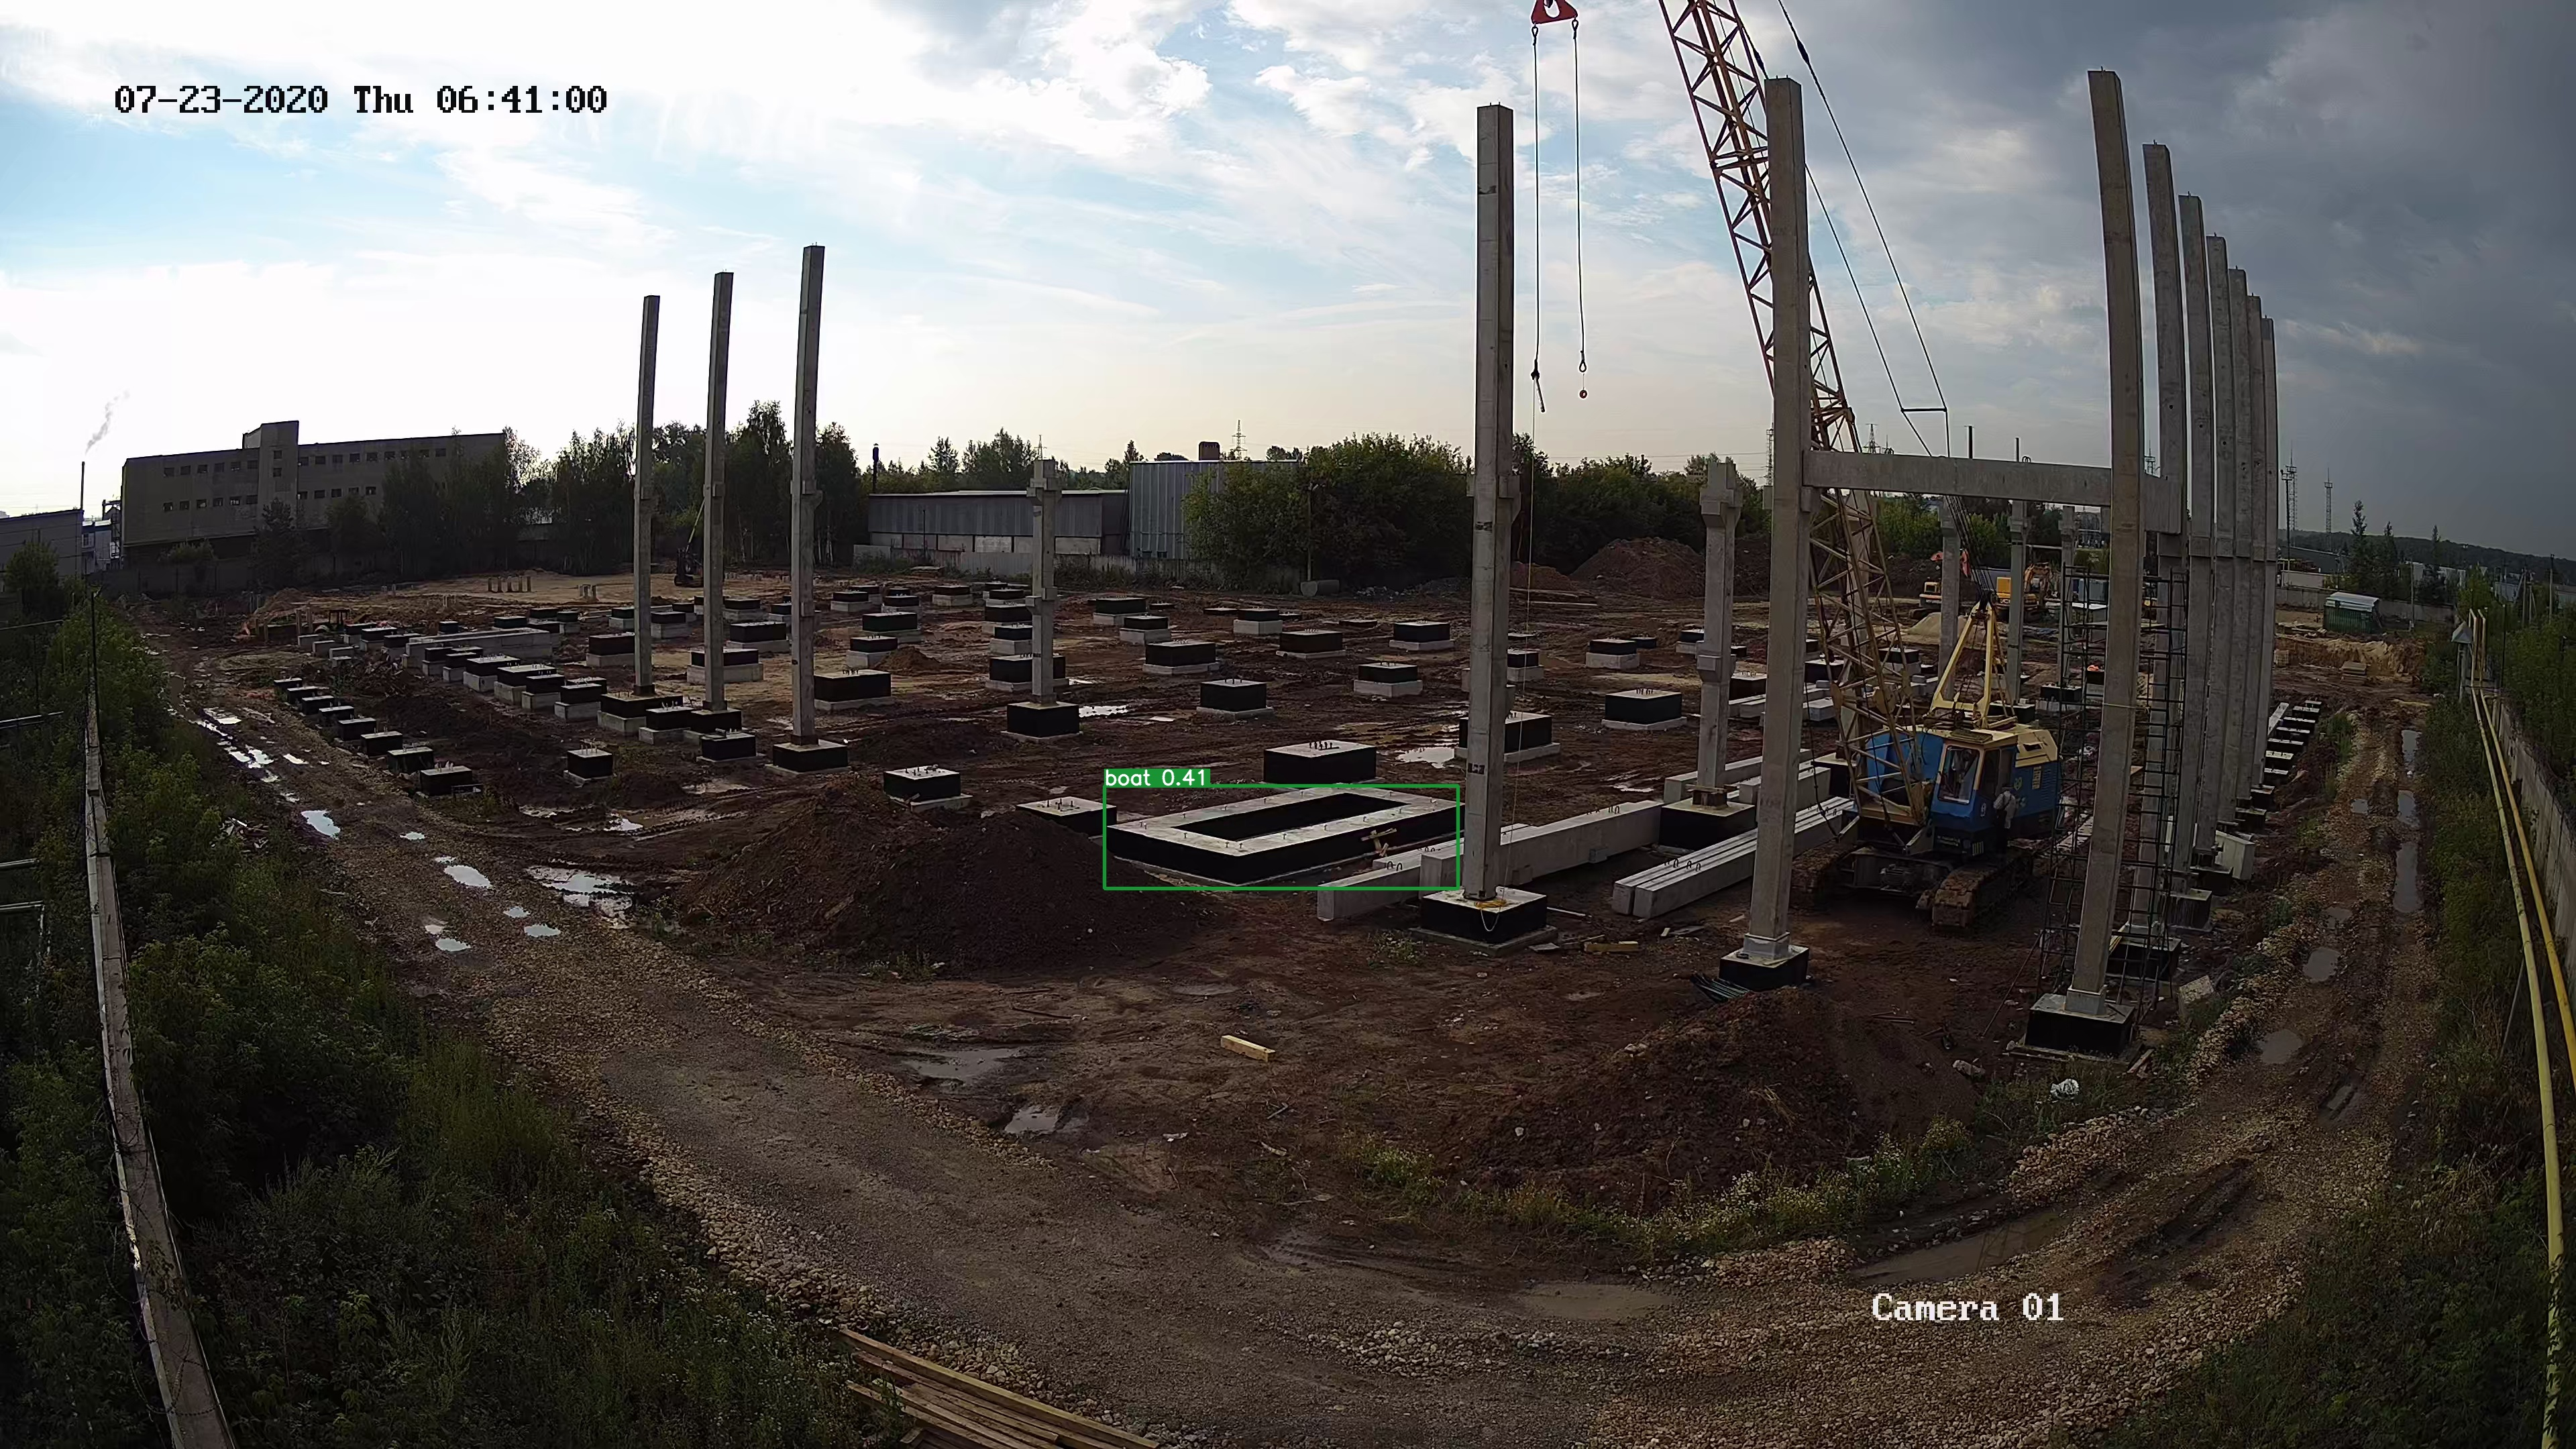

In [15]:
Image(filename='/content/runs/detect/predict/_15_004325.jpg', height=600)

добавим дашборд

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('runs/construction_detection')

In [17]:
model = YOLO('yolov8n.pt')

In [16]:
def image_description_yolo8(image_data: pd.DataFrame, path: str = '/content/datasets/Датасеты/Персонал/dataset/images') -> np.array:
    image_id = image_data['image_id'].values[0]
    image_path = image_data['image_path'].values[0][4:]
    img = cv2.cvtColor(
        cv2.imread(os.path.join(path, image_path)),
        cv2.COLOR_BGR2RGB
    )
    img_height, img_width, _ = img.shape
    result_description = []
    
    for idx, row in image_data.iterrows():
        category_id = row['category_id']
        bbox = row['bbox']
        x1, y1, obj_width, obj_height = tuple(bbox)
        x_center = x1 + (obj_width / 2)
        y_center = y1 + (obj_height / 2)
        x_center /= img_width
        obj_width /= img_width
        y_center /= img_height
        obj_height /= img_height
        desc = {
            'category_id': category_id,
            'x_center': x_center,
            'y_center': y_center,
            'bbox_width': obj_width,
            'bbox_height': obj_height
        }
        result_description.append(desc)
        
    return pd.DataFrame(result_description)


def prepare_folders_2():
    if not os.path.exists('yolo_model_dataset_2'):
        os.makedirs('yolo_model_dataset_2')
    
    os.makedirs('./yolo_model_dataset_2/train/images')
    os.makedirs('./yolo_model_dataset_2/train/labels')
    
    os.makedirs('./yolo_model_dataset_2/val/images')
    os.makedirs('./yolo_model_dataset_2/val/labels')
    
    
def split_images(annotations_df: pd.DataFrame, test_size: float = 0.2, random_state = 5) -> pd.DataFrame:
    images_to_split = annotations_df['image_id'].unique()

    images_train, images_val = train_test_split(images_to_split, test_size=test_size, random_state=5)

    train_images = pd.Series(index=images_train, data=1)
    val_images = pd.Series(index=images_val, data=0)

    images_splitted = pd.concat([train_images, val_images])

    annotations_df['is_train'] = annotations_df['image_id'].map(images_splitted)
    return annotations_df

    
def copy_images2(annotations_df: pd.DataFrame, test_size: float = 0.2, images_path: str = '/content/datasets/Датасеты/Персонал/dataset/images'):
    
    if 'is_train' not in annotations_df.columns:
        annotations_df = split_images(annotations_df)
    
    for image_id in tqdm(annotations_df['image_id'].unique()):
        cur_image_data = annotations_df.loc[
            annotations_df['image_id'] == image_id
        ]
        image_path = cur_image_data['image_path'].values[0][4:]
        is_train = annotations_df[annotations_df['image_id'] == image_id]['is_train'].values[0]
        
        image_description = image_description_yolo8(cur_image_data, images_path)
        image_name = os.path.basename(image_path)
        
        if is_train:
            shutil.copy(
                os.path.join(images_path, image_path),
                os.path.join('./yolo_model_dataset_2/train/images', image_name)
            )
            image_description.to_csv(
                os.path.join('./yolo_model_dataset_2/train/labels', image_name.replace('.jpg', '.txt')),
                index=False,
                header=False,
                sep=' '
            )
            
        else:
            shutil.copy(
                os.path.join(images_path, image_path),
                os.path.join('./yolo_model_dataset_2/val/images', image_name)
            )
            image_description.to_csv(
                os.path.join('./yolo_model_dataset_2/val/labels', image_name.replace('.jpg', '.txt')),
                index=False,
                header=False,
                sep=' '
            )

In [18]:
prepare_folders_2()
copy_images2(annotations_df)

100%|██████████| 2392/2392 [03:18<00:00, 12.04it/s]


In [19]:
import yaml

custom = {'path':  '/content/yolo_model_dataset_2',
           'train': './train/images',
           'val': './val/images',
            'names': {3: 'person',
 4: 'vest',
 5: 'vest_viol',
 6: 'helmet',
 7: 'helmet_viol',
 8: 'welding_mask',
 9: 'head_hood',
 10: 'person_nik',
 11: 'head_unknown'}
         }

# Convert Python dictionary into a YAML document
with open(r'custom.yaml', 'w') as file:
    documents = yaml.dump(custom, file)

In [21]:
# Use the model
results = model.train(data='custom.yaml', epochs=5)  # train the model
success = model.export(format='onnx')  # export the model to ONNX format

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=custom.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, workspace=4, nms=False, lr0=0.0

IndexError: ignored

In [ ]:
!pwd

/content


In [ ]:
!find /content/yolo_model_dataset/train/labels -type f | wc -l

1873


In [ ]:
!find /content/yolo_model_dataset/train/images -type f | wc -l

1873


In [ ]:
!cd /yolo_model_dataset_2 tree

/bin/bash: line 0: cd: too many arguments


НИЖЕ КОД ДЛЯ ОБУЧЕНИЯ МОДЕЛИ

In [ ]:
!pip3 install torch torchvision torchaudio
!pip3 install split-folders

проверим, что GPU включен

In [ ]:
img = np.asarray(Image.open('/content/datasets/Датасеты/Персонал/dataset/images/2020-10-16/_8/_8_000350.jpg'))